# Shuffle DP kRR Frequency Estimation under Poisoning Attack

This notebook studies the robustness of Shuffle DP using the k-ary Randomized Response (kRR) mechanism under poisoning attacks.

We simulate two attack types under both Uniform and Zipf distributions:
- **OPA**: Output Poisoning Attack (malicious users submit target label directly)
- **IPA**: Input Poisoning Attack (malicious users feed fake values through the mechanism)

To achieve effective privacy ε′ = 1.0 under Shuffle DP, the true local ε should satisfy:
$$ \varepsilon' = O\left(\sqrt{\frac{\beta(e^{\varepsilon_0}-1)\log(1/\delta)}{n}}\right), \text{ where } \beta \in \left[0, \frac{p-1}{p+1}\right], \text{ and } p = e^{\varepsilon_0} $$


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Parameters
n = 10000
k = 20
epsilon_prime = 1.0
delta = 1e-5
beta = 1  # a reasonable estimate within the bound of (p-1)/(p+1)
target_bin = 0
gamma_values = np.linspace(0, 0.3, 5)
num_trials = 5

# Compute true epsilon_0 from tight amplification bound
def compute_true_epsilon(epsilon_prime, beta, delta, n):
    from scipy.optimize import minimize_scalar
    def loss(eps0):
        p = np.exp(eps0)
        rhs = np.sqrt((beta * (p - 1) * np.log(1 / delta)) / n)
        return (rhs - epsilon_prime)**2
    res = minimize_scalar(loss, bounds=(0.01, 10), method='bounded')
    return res.x

epsilon = compute_true_epsilon(epsilon_prime, beta, delta, n)

In [7]:
# Utilities
def krr_probabilities(k, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)
    q = (1 - p) / (k - 1)
    return p, q

def zipf_distribution(k, s=1.0):
    ranks = np.arange(1, k + 1)
    weights = 1 / np.power(ranks, s)
    return weights / weights.sum()

# Simulation
def simulate_krr(n, k, epsilon, gamma, target_bin, true_freq, attack_type):
    p, q = krr_probabilities(k, epsilon)
    n_corrupt = int(gamma * n)
    n_honest = n - n_corrupt
    honest_data = np.random.choice(k, size=n_honest, p=true_freq)
    reports = []
    for x in honest_data:
        probs = np.full(k, q)
        probs[x] = p
        reports.append(np.random.choice(k, p=probs))
    if attack_type == "OPA":
        reports += [target_bin] * n_corrupt
    elif attack_type == "IPA":
        for _ in range(n_corrupt):
            probs = np.full(k, q)
            probs[target_bin] = p
            reports.append(np.random.choice(k, p=probs))
    reports = np.array(reports)
    est_freq = np.zeros(k)
    for i in range(k):
        count = np.sum(reports == i)
        est_freq[i] = (count / n - q) / (p - q)
    return np.clip(est_freq[target_bin], 0, 1)

In [8]:
# Run experiment
def run_experiment(true_freq):
    results = {"OPA": [], "IPA": []}
    for gamma in gamma_values:
        for attack in ["OPA", "IPA"]:
            trials = [simulate_krr(n, k, epsilon, gamma, target_bin, true_freq, attack) for _ in range(num_trials)]
            mean = np.mean(trials)
            std = np.std(trials)
            results[attack].append((gamma, mean, mean - 2 * std, mean + 2 * std))
    return results

# Plot

def plot_results(results, title, true_freq):
    plt.figure(figsize=(8, 5))
    for attack, color in zip(["OPA", "IPA"], ["red", "blue"]):
        arr = np.array(results[attack])
        plt.plot(arr[:, 0], arr[:, 1], marker='o', label=attack, color=color)
        plt.fill_between(arr[:, 0], arr[:, 2], arr[:, 3], color=color, alpha=0.2)
    plt.axhline(true_freq[target_bin], color='black', linestyle='--', label='True Frequency')
    plt.xlabel("Corruption Ratio γ")
    plt.ylabel("Estimated Frequency")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

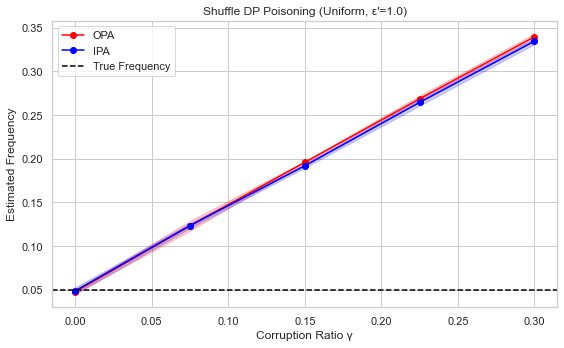

In [9]:
# Uniform
uniform_freq = np.ones(k) / k
uniform_results = run_experiment(uniform_freq)
plot_results(uniform_results, "Shuffle DP Poisoning (Uniform, ε′=1.0)", uniform_freq)

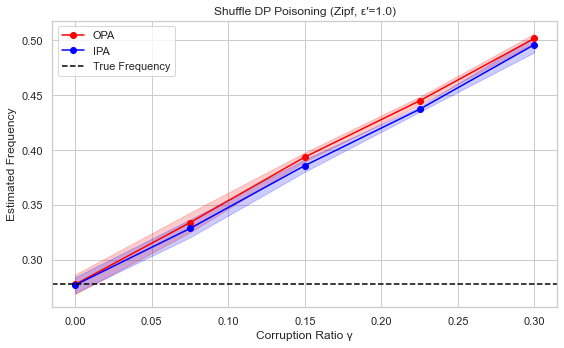

In [10]:
# Zipf
zipf_freq = zipf_distribution(k)
zipf_results = run_experiment(zipf_freq)
plot_results(zipf_results, "Shuffle DP Poisoning (Zipf, ε′=1.0)", zipf_freq)

## Conclusion

This notebook shows how poisoning attacks under Shuffle DP can affect the accuracy of frequency estimation even under tight amplification settings. We observe:

- **OPA (Output Poisoning)** remains more damaging, since it bypasses the randomizer, especially as corruption ratio γ increases.
- **IPA (Input Poisoning)**, while limited by noise, still causes noticeable bias.
- **Zipf distributions** tend to amplify the impact on highly ranked bins due to their skewed nature.

Compared with Local DP (LDP) under the same effective privacy budget (ε′), Shuffle DP shows significantly better robustness against Input Poisoning Attacks, due to noise centralization. However, Shuffle DP remains vulnerable to Output Poisoning Attacks if attackers can directly influence outputs. LDP's local randomization prevents such direct manipulation, but suffers from higher variance overall.

Mitigation strategies in real-world deployments should consider both the input control limitations (as in AMP-SDP) and scalable shuffling architectures to reduce the impact of OPA.